# Sentiment Analyse mit Transformers

Zielsetzung: In diesem Notebook verwenden wir einen Transformer zur Analyse unserer Daten. Basierend auf den Erkenntnissen aus dem vorherigen Kapitel sollte dieser theoretisch eine schlechtere Performance aufweisen als das Bag-of-Words-Modell aus den ersten Notebooks, jedoch besser abschneiden als das LSTM-Modell.

Alle Imports:

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers
from utils.text_utils import clean_text
from utils.plot_utils import plot_history_metrics, get_classification_report

## Reduzierte Ausführungszeit durch lokale Ausführung
Da nicht jeder über eine leistungsstarke Grafikkarte mit GPU-Unterstützung verfügt, kann die Ausführung von LSTMs zeitaufwändig sein. Eine effektive Alternative zur lokalen Ausführung bietet Google Colab. Dieser Dienst ermöglicht die kostenlose Ausführung des Codes mit GPU-Unterstützung. Obwohl die Authentifizierung bei Diensten wie Kaggle etwas komplexer sein kann, haben wir in den Notebooks Tools integriert, die eine einfache Authentifizierung in Google Colab ermöglichen.

## Authentifizierung bei Kaggle
Navigieren Sie zu https://www.kaggle.com. Gehen Sie dann zu Ihrem [Benutzerprofils](https://www.kaggle.com/me/account) und wählen Sie "API-Token erstellen" aus. Dadurch wird die Datei kaggle.json heruntergeladen, die Ihre API-Zugangsdaten enthalten.

Führen Sie anschließend die nachstehende Zelle aus, um kaggle.json in Ihrer Colab-Laufzeit hochzuladen.

In [ ]:
# Don't run this if you run the notebook locally
from google.colab import files
    
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

## Herunterladen der Daten

In [3]:
import os

# Download McDonalds dataset
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading McDonalds dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unzipping McDonalds dataset...")
    !unzip -n mcdonalds-store-reviews.zip

# Download IMDB dataset
if not os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Downloading IMDB dataset...")
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
if os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Unzipping IMDB dataset...")
    !unzip -n imdb-dataset-of-50k-movie-reviews.zip

Unzipping McDonalds dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  mcdonalds-store-reviews.zip
Unzipping IMDB dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  imdb-dataset-of-50k-movie-reviews.zip


## Prozessierung der Daten
Die Prozessierung wird nicht weiterbeschrieben, weil sie identisch zum letzten Notebook ist. 

In [5]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')

In [6]:
df_mc.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [7]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df_mc['review'] = df_mc['review'].apply(clean_text)
df_imdb['review'] = df_imdb['review'].apply(clean_text)

In [9]:
df_mc = df_mc[['review', 'rating']]
df_imdb = df_imdb[['review', 'sentiment']]

In [10]:
df_mc.head()

,review,rating
0,look like someone spit food normal transaction...,1 star
1,itd mcdonalds far food atmosphere go staff mak...,4 stars
2,made mobile order got speaker checked line mov...,1 star
3,mc crispy chicken sandwich customer service qu...,5 stars
4,repeat order times drive thru still manage mes...,1 star


In [11]:
df_imdb.head()

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [13]:
df_mc = df_mc[df_mc['rating'] != '3 stars']
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()
rating_mapping_imdb = {
    'positive': 1,
    'negative': 0,
}

label_imdb = df_imdb['sentiment'].map(rating_mapping_imdb).to_numpy()
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

label_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb,label_mc)

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

## Word-Embeddings
Wir nutzen das gleiche Encoding für den Transformer wie schon im LSTM.

In [14]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=None,
)
text_vectorization.adapt(train_data)
text_vectorization.adapt(test_data)

int_train_ds = text_vectorization(train_data)

int_test_ds = text_vectorization(test_data)

## Transformer-Encoder 
Self Attention:

Bei Self-Attention geht es darum, eine Beziehung zwischen verschiedenen Tokens innerhalb einer Sequenz herzustellen, um die wichtigsten Informationen zu identifizieren und zu betonen. 

Der Prozess der Self-Attention besteht aus drei grundlegenden Schritten:

1. Berechnung von Schlüssel-, Wert- und Abfragevektoren: Jedes Token in der Eingabesequenz wird in drei Vektoren transformiert - Schlüssel (Key), Wert (Value) und Abfrage (Query). 


2. Berechnung der Aufmerksamkeitsgewichte: Für jedes Token in der Sequenz werden Aufmerksamkeitsgewichte berechnet, um seine Beziehung zu anderen Tokens zu bestimmen. Dies geschieht, indem das Skalarprodukt zwischen dem Abfragevektor des aktuellen Tokens und den Schlüsselvektoren aller anderen Tokens berechnet wird. Durch die Anwendung einer Softmax-Funktion auf diese Skalarprodukte werden die Aufmerksamkeitsgewichte normalisiert.
> output = sum(values x pairwise-scores(query, keys))

3. Aggregation der Wertvektoren: Die Aufmerksamkeitsgewichte werden verwendet, um gewichtete Summen der Wertvektoren zu berechnen. Dies ermöglicht die Gewichtung der relevanten Informationen jedes Tokens entsprechend den Aufmerksamkeitsgewichten. Das Ergebnis ist der aggregierte Ausgabevektor für das aktuelle Token.

## Was sind die Query, Keys and Values in unserem Model?
In unserem Sequence-to-Sequence-Modell sind die Query, Keys und Values alles die gleichen inputs. Sie repräsentieren die Sequenz selbst, die mit sich selbst verglichen wird, um jedes Token mit Kontextinformationen aus der gesamten Sequenz anzureichern. In diesem Fall werden die Query-, Keys- und Values-Vektoren verwendet, um den Self-Attention-Mechanismus anzuwenden und wichtige Beziehungen und Zusammenhänge innerhalb der Sequenz zu erfassen.

<img src="assets/ScaledDotProduct.jpeg" alt="Multi Head Attention" width="200"/>ee


## Multi-Head Attention 
Der "Multi-head attention" Layer wurde in dem Paper "Attention is all you need" eingeführt. Der Begriff "multi-head" bezieht sich darauf, dass der Self-Attention Layer in eine Reihe unabhängiger Teilräume aufgeteilt wird. Diese lernen unabhängig voneinander. 

Die Query, Key und Value Vektoren werden durch drei separate Layern von dichten Projektionen geschickt, was zu drei separaten Vektoren führt. Jeder Vektor wird mit Hilfe von Self Attention verarbeitet, und die drei Ausgaben werden wieder zu einem einzelnen Output zusammengefügt. Jeder solche Teilraum wird als "head" bezeichnet.

Die dense Layers ermöglichen es der Gesamtschicht wirklich etwas zu lernen, ansonsten würde es sich nur um eine zustandslose Transformation handeln. Darüber hinaus hilft die Verwendung unabhängiger Heads der Schicht dabei, verschiedene Gruppen von Merkmalen für jedes Token zu lernen, wobei die Merkmale innerhalb einer Gruppe miteinander korreliert sind, aber größtenteils unabhängig von Merkmalen in einer anderen Gruppe sind.



<img src="assets/MultiHead.png" alt="Multi Head Attention" width="500"/>


## Transformer-Encoder 
Ein Transformer besteht aus einem Encoder und einem Decoder. Für unsere Sentiment-Analyse verwenden wir nur den Encoder, da wir keine neuen Sequenzen generieren müssen. Der Kern des Encoders ist der Multi-Head-Attention-Layer, der gerade erläutert wurde. Zusätzlich enthält der Encoder zusätzliche Dense-Layer, um weitere Beziehungen zwischen den Tokens zu erfassen. Residualverbindungen werden verwendet, um sicherzustellen, dass die Dense-Layer keine Informationen zerstören, und Normalisierungsschichten tragen dazu bei, die Daten auf zum Beispiel einen bestimmten Mittelwert zu normalisieren, was das Training stabiler und schneller macht.

<img src="assets/TransformerEncoder.png" alt="Transformer Encoder" width="300"/>


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

## Self Attention Model mit Wordembedding


In [16]:
# Hyperparameter
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32


In [17]:
def getTransformerEncoderModel():
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = layers.Embedding(vocab_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
    return model

encoderModel = getTransformerEncoderModel()
encoderModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

Der Großteil der Komplexität dieses Modells liegt im Transformer Encoder. Wir müssen lediglich die Rückgabewerte des Encoders umwandeln, da er nur vollständige Sequenzen zurückgibt. Wir benötigen jedoch einzelne Vektoren, um die Daten zu klassifizieren. Daher nutzen wir einen GlobalMaxPooling1D Layer, um die Daten zu reduzieren.

In [18]:
callbacks = [
  keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]

In [21]:
encoderModel.fit(int_train_ds, train_label, validation_split=0.2, epochs=20, callbacks=callbacks, verbose=1)

Epoch 1/20
1572/1572 [==============================] - 79s 50ms/step - loss: 0.3761 - accuracy: 0.8307 - val_loss: 0.3135 - val_accuracy: 0.8669
Epoch 2/20
1572/1572 [==============================] - 43s 27ms/step - loss: 0.3132 - accuracy: 0.8650 - val_loss: 0.2882 - val_accuracy: 0.8790
Epoch 3/20
1572/1572 [==============================] - 37s 24ms/step - loss: 0.2866 - accuracy: 0.8794 - val_loss: 0.2805 - val_accuracy: 0.8821
Epoch 4/20
1572/1572 [==============================] - 35s 23ms/step - loss: 0.2708 - accuracy: 0.8883 - val_loss: 0.2821 - val_accuracy: 0.8810
Epoch 5/20
1572/1572 [==============================] - 34s 22ms/step - loss: 0.2539 - accuracy: 0.8971 - val_loss: 0.2840 - val_accuracy: 0.8831
Epoch 6/20
1572/1572 [==============================] - 34s 21ms/step - loss: 0.2398 - accuracy: 0.9032 - val_loss: 0.2775 - val_accuracy: 0.8852
Epoch 7/20
1572/1572 [==============================] - 31s 20ms/step - loss: 0.2232 - accuracy: 0.9115 - val_loss: 0.2926 -

In [22]:
encoderModel.evaluate(int_test_ds, test_label)

492/492 [==============================] - 5s 9ms/step - loss: 0.2748 - accuracy: 0.8877


[0.27477791905403137, 0.8876940608024597]

## Hinzufügen von PositionalEmbedding
Die Ergebnisse mit unserem Transformer-Layer sind bereits vielversprechend. Allerdings nutzen wir bisher nur einen der beiden wesentlichen Bestandteile, die den Transformer so leistungsstark machen: den Self Attention Mechanismus. Bisher hatte unser Modell keine Kenntnis über die Reihenfolge der Wörter, obwohl diese einen großen Unterschied in der Bedeutung des Satzes ausmachen können. Um dies zu verbessern, werden wir das Positional Embedding hinzufügen, um die Reihenfolge der Wörter zu berücksichtigen und so die Leistung unseres Modells weiter zu steigern.

Der aktuelle Transformer würde diese beiden Sätze identisch bewerten:

> "Eventough I did _**not**_ like the new mayo formula I was satisfied"

> "Eventough I did like the new mayo formula I was _**not**_ satisfied"

Ein Ansatz zur Integration von positionellen Daten besteht darin, die Daten sequenziell zu verarbeiten. Dieser Ansatz wird auch von LSTMs verwendet, um positionelle Daten in ihre Modelle einzufügen. Es ist jedoch wichtig zu beachten, dass dieser sequenzielle Ansatz keine parallele Verarbeitung ermöglicht. 

Im Paper "Attention is all you need" wird das Problem der Positionsdaten durch die Anreicherung des Word Embedding Vektors mit positionellen Informationen gelöst. Dieser Ansatz besteht darin, Sinus- und Kosinuswellenfrequenzen zu verwenden, um die Positionsdaten zu kodieren.

Anstatt separate Positional Embeddings zu verwenden oder die Daten sequenziell zu verarbeiten, fügt das Paper die Positionsdaten direkt in den Word Embedding Vektor ein. Hierzu werden Sinus- und Kosinusfunktionen mit unterschiedlichen Frequenzen verwendet, um die Positionsinformationen zu kodieren. Diese Sinus- und Kosinuswerte werden dann mit den Word Embedding Vektoren addiert.

Durch die Verwendung von Sinus- und Kosinusfrequenzen in den Word Embedding Vektoren kann der Transformer-Modellarchitektur die Positionsinformationen der Wörter erfassen, ohne dass eine sequenzielle Verarbeitung oder separate Positional Embeddings erforderlich sind.


Im Bild und der Grafik unter diesem Text wird dies systematisch erklärt. Als Beispiel nehmen wir den Satz:

 > Die Prüfung war schwer
 
  als unseren Input.

Schauen wir uns das Wort "Prüfung" genauer an. Zuerst wird ihm ein Index aus dem Wörterbuch zugewiesen. Anschließend wird ein Word Embedding Vektor generiert. In diesem Beispiel werden nur 5 Dimensionen genutzt, während es in der Realität oft deutlich mehr sind. Im Paper "Attention is all you need" werden beispielsweise 512 Dimensionen verwendet. Für das Positional Embedding wird ein Vektor mit derselben Größe generiert wie für das Word Embedding.

Die Daten in diesem Vektor werden mithilfe der Wortposition (2), der Anzahl der Dimensionen (5) und des Index (0-4) ermittelt. Durch die Indexierung kann das Embedding über verschiedene Frequenzen hinweg die Wortposition vergleichen. Wie in der Grafik zu sehen ist, können zwei Wörter eine ähnliche Frequenz haben, wie zum Beispiel P0 und P2 bei i = 4.

Wenn das Modell nur i = 4 verwenden würde, um die Position zu ermitteln, hätte es Schwierigkeiten, die richtige Wortreihenfolge aus den Daten abzuleiten. Glücklicherweise besitzt es jedoch noch weitere Dimensionen, wie z.B. i = 2. In der Grafik können wir sehen, dass sich die Frequenz von P0 und P2 bei i = 2 deutlich unterscheiden.


<img src="assets/PositonalEmbedding.jpeg" alt="PositionalEncoding" width="1000"/>


<img src="assets/Frequenzen.png" alt="PositionalEncoding" width="500"/>


In [24]:
class PositionEmbeddingSinCos(layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingSinCos, self).__init__(**kwargs)
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=output_dim)
        self.position_embedding_layer = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix]            )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_tokens = self.token_embeddings(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_tokens + embedded_indices

In [25]:
def getPositonalEmbeddingModel():
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = PositionEmbeddingSinCos(sequence_length,vocab_size,embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
    return model
positonalModel = getPositonalEmbeddingModel()
positonalModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 position_embedding_sin_cos   (None, None, 256)        5273600   
 (PositionEmbeddingSinCos)                                       
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

In [27]:
history_with_pos_enc = positonalModel.fit(int_train_ds,train_label, validation_split=0.2, epochs=20, callbacks=callbacks, verbose=1)


Epoch 1/20
1572/1572 [==============================] - 43s 27ms/step - loss: 0.4969 - accuracy: 0.7497 - val_loss: 0.4488 - val_accuracy: 0.7811
Epoch 2/20
1572/1572 [==============================] - 39s 25ms/step - loss: 0.4204 - accuracy: 0.8062 - val_loss: 0.4074 - val_accuracy: 0.8178
Epoch 3/20
1572/1572 [==============================] - 38s 24ms/step - loss: 0.3853 - accuracy: 0.8277 - val_loss: 0.3935 - val_accuracy: 0.8188
Epoch 4/20
1572/1572 [==============================] - 36s 23ms/step - loss: 0.3636 - accuracy: 0.8410 - val_loss: 0.3693 - val_accuracy: 0.8348
Epoch 5/20
1572/1572 [==============================] - 37s 24ms/step - loss: 0.3457 - accuracy: 0.8510 - val_loss: 0.3617 - val_accuracy: 0.8360
Epoch 6/20
1572/1572 [==============================] - 36s 23ms/step - loss: 0.3300 - accuracy: 0.8583 - val_loss: 0.3607 - val_accuracy: 0.8408
Epoch 7/20
1572/1572 [==============================] - 36s 23ms/step - loss: 0.3207 - accuracy: 0.8636 - val_loss: 0.3539 -

In [28]:
positonalModel.evaluate(int_test_ds, test_label)

492/492 [==============================] - 5s 11ms/step - loss: 0.3456 - accuracy: 0.8470


[0.3455508351325989, 0.8470348715782166]

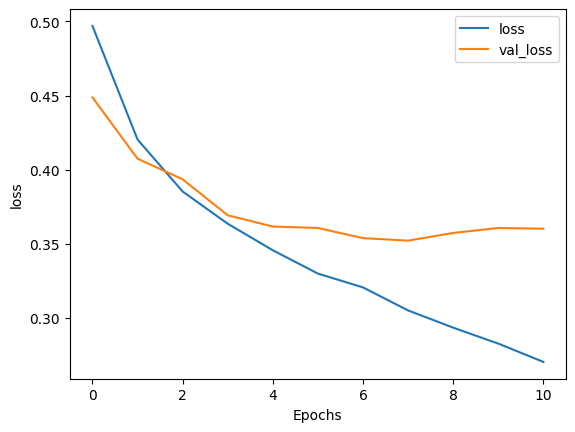

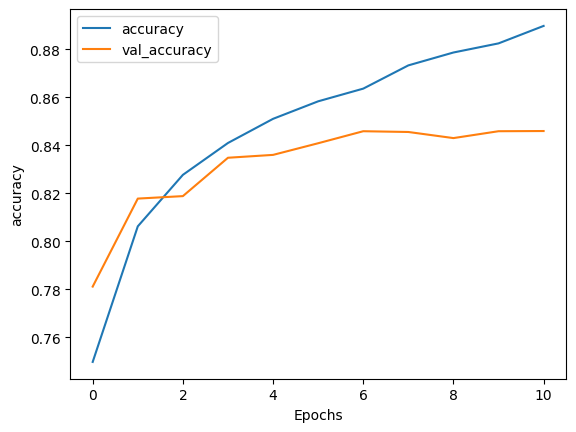

In [30]:
plot_history_metrics(history_with_pos_enc, ['loss', 'accuracy'])

## Simpleres Positional Encoding
Bevor wir das Positional Embedding nach der "Attention is all you need"-Methode implementiert haben, haben wir ein einfacheres Positional Embedding verwendet. Dabei haben wir den Wordindex direkt als Positional Embedding Vektor erstellt und mit dem Word Embedding Vektor addiert. Überraschenderweise erzielte dieser einfache Ansatz die beste Performance unter allen drei Transformer-Modellen. Obwohl wir keine konkrete Erklärung dafür haben, könnten möglicherweise die Hyperparameter besser zu diesem Ansatz passen oder die Größe des Vokabulars (vocab_size) von 600 hier eine Rolle spielen. Wir wären gespannt auf ihre Meinung zu dieser Auswirkung!

In [31]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [32]:
def getSimplePosModel():
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = PositionalEmbedding(sequence_length,vocab_size,embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
    return model
simplePosModel = getSimplePosModel() 
simplePosModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder_2 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                           

In [34]:

history_simple_pos_enc = simplePosModel.fit(int_train_ds,train_label, validation_split=0.2, epochs=20, callbacks=callbacks, verbose=1)


Epoch 1/20
1572/1572 [==============================] - 67s 43ms/step - loss: 0.3603 - accuracy: 0.8413 - val_loss: 0.2962 - val_accuracy: 0.8757
Epoch 2/20
1572/1572 [==============================] - 42s 27ms/step - loss: 0.2577 - accuracy: 0.8973 - val_loss: 0.2729 - val_accuracy: 0.8836
Epoch 3/20
1572/1572 [==============================] - 39s 25ms/step - loss: 0.2311 - accuracy: 0.9082 - val_loss: 0.2771 - val_accuracy: 0.8860
Epoch 4/20
1572/1572 [==============================] - 37s 24ms/step - loss: 0.2132 - accuracy: 0.9168 - val_loss: 0.2679 - val_accuracy: 0.8945
Epoch 5/20
1572/1572 [==============================] - 37s 24ms/step - loss: 0.1951 - accuracy: 0.9260 - val_loss: 0.3096 - val_accuracy: 0.8842
Epoch 6/20
1572/1572 [==============================] - 37s 23ms/step - loss: 0.1799 - accuracy: 0.9322 - val_loss: 0.2758 - val_accuracy: 0.8954
Epoch 7/20
1572/1572 [==============================] - 36s 23ms/step - loss: 0.1670 - accuracy: 0.9377 - val_loss: 0.3365 -

In [35]:
simplePosModel.evaluate(int_test_ds, test_label)

492/492 [==============================] - 5s 11ms/step - loss: 0.2582 - accuracy: 0.8972


[0.2581506669521332, 0.8972384929656982]

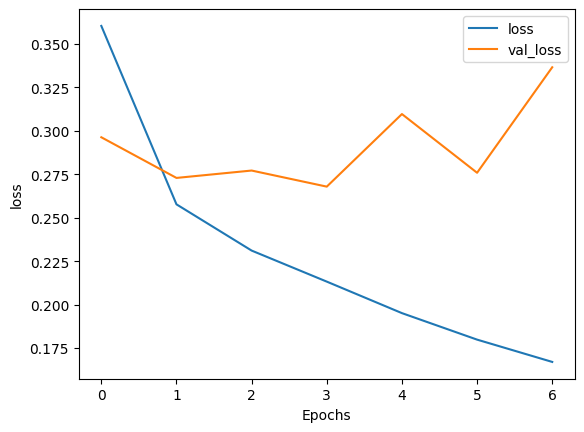

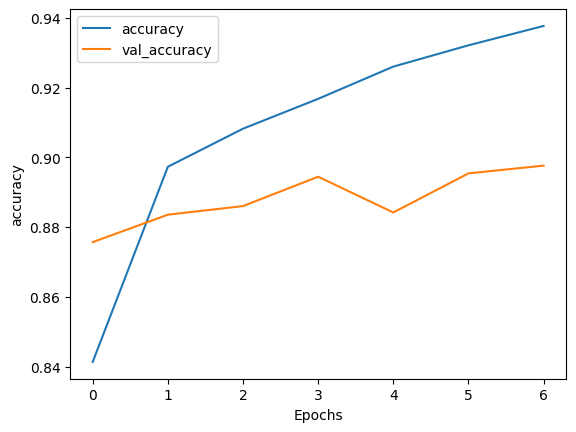

In [36]:
plot_history_metrics(history_simple_pos_enc, ['loss', 'accuracy'])

# Fazit
Wie im LSTM-Notebook bereits festgestellt wurde, sind Transformer nicht unbedingt die ideale Wahl für die Menge der vorliegenden Daten. Obwohl die Ergebnisse des Transformer-Modells minimal besser sind als die des LSTM-Modells, liegen sie nur fast auf dem Niveau der Bag-of-Words-Ansätze. Allerdings ist die Ausführungszeit des Transformer-Modells um ein Vielfaches höher. Wenn wir die Ausführungszeit und die noch vorhandenen Möglichkeiten der Hyperparameter-Optimierung im Bag-of-Words-Ansatz berücksichtigen, überwiegen die Vorteile der Bag-of-Words-Methodik deutlich.

Jedoch, wenn wir beabsichtigen, ein allgemeines Modell zu erstellen, das eine deutlich größere Anzahl von Reviews verarbeiten kann, dann ist die Transformer-Architektur die richtige Wahl. Insbesondere der Attention-Mechanismus und die parallel ausführbaren Positional Encodings machen sie in diesem Fall zur besten Wahl.